In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import warnings
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import xgboost as xgb



warnings.filterwarnings('ignore')


In [2]:
#Read data from csv files into the respective Dataframes
sales_df=pd.read_csv(r'D:\ranjiny\Guvi_python\Capstone_Dominos\Pizza_Sale-pizza_sales.csv')
ingredient_df=pd.read_csv(r'D:\ranjiny\Guvi_python\Capstone_Dominos\Pizza_ingredients-Pizza_ingredients.csv')

In [3]:
#Sales Dataset analysis

print(sales_df.isna().sum())
print(sales_df.info())
print(sales_df.describe())

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ing

In [4]:
#Ingredient Dataset analysis

print(ingredient_df.isna().sum())
print(ingredient_df.info())
print(ingredient_df.describe())


pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB
None
       Items_Qty_In_Grams
count          514.000000
mean            30.564202
std             30.351623
min              5.000000
25%             10.000000
50%             20.000000
75%             40.000000
max            200.000000


In [5]:
#Step1: Data Preprocessing and Exploration

#Step 1 a: Data Cleaning:
#Filling missing values
most_common_category = dict(sales_df.groupby('pizza_name')['pizza_category'].agg(lambda x: x.mode()[0]))
sales_df['pizza_category']=sales_df['pizza_category'].fillna(sales_df['pizza_name'].map(most_common_category))

most_common_ingredients = dict(sales_df.groupby('pizza_name')['pizza_ingredients'].agg(lambda x: x.mode()[0]))
sales_df['pizza_ingredients']=sales_df['pizza_ingredients'].fillna(sales_df['pizza_name'].map(most_common_ingredients))

sales_df['total_price']=sales_df['total_price'].fillna(sales_df['quantity']*sales_df['unit_price'])

most_common_name = dict(sales_df.groupby('pizza_name_id')['pizza_name'].agg(lambda x: x.mode()[0]))
sales_df['pizza_name']=sales_df['pizza_name'].fillna(sales_df['pizza_name_id'].map(most_common_name))

most_common_name_id = dict(sales_df.groupby(['pizza_name','pizza_size'])['pizza_name_id'].agg(lambda x: x.mode()[0]))
sales_df['pizza_name_id'] = sales_df['pizza_name_id'].fillna(sales_df.apply(lambda x: most_common_name_id.get((x['pizza_name'], x['pizza_size']), None), axis=1))


ingredient_df=ingredient_df.bfill()

In [6]:
#Formatting date column
sales_df['order_date']=sales_df['order_date'].str.replace('/','-')
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'],format='%d-%m-%Y')


In [7]:
!pip install holidays

In [8]:
#2a:Feature Engineering
sales_df['month'] = sales_df['order_date'].dt.month
sales_df['day_of_week'] = sales_df['order_date'].dt.dayofweek


ind_holidays=holidays.India(years=2015)
sales_df['ind_holiday']=sales_df['order_date'].apply(lambda x:1 if x in(ind_holidays) else 0)

sales_df['promotions']=sales_df['day_of_week'].apply(lambda x:1 if x > 4 else 0)




In [9]:
#Step 1b:Exploratory Data Analysis (EDA):
sales_df.describe()

,pizza_id,order_id,quantity,order_date,unit_price,total_price,month,day_of_week,ind_holiday,promotions
count,48620.000000,48620.000000,48620.000000,48620,48620.000000,48620.000000,48620.000000,48620.000000,48620.000000,48620.000000
mean,24310.500000,10701.479761,1.019622,2015-06-29 11:03:43.611682560,16.494132,16.821474,6.451131,3.023797,0.048108,0.272974
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.750000,1.000000,0.000000,0.000000,0.000000
25%,12155.750000,5337.000000,1.000000,2015-03-31 00:00:00,12.750000,12.750000,3.000000,1.000000,0.000000,0.000000
50%,24310.500000,10682.500000,1.000000,2015-06-28 00:00:00,16.500000,16.500000,6.000000,3.000000,0.000000,0.000000
75%,36465.250000,16100.000000,1.000000,2015-09-28 00:00:00,20.250000,20.500000,9.000000,5.000000,0.000000,1.000000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,83.000000,12.000000,6.000000,1.000000,1.000000
std,14035.529381,6180.119770,0.143077,NaN,3.621789,4.437398,3.435420,1.934155,0.213996,0.445492


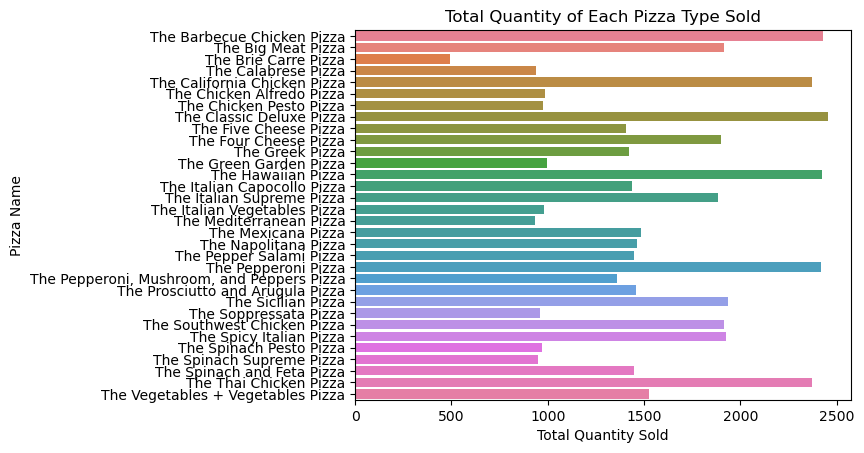

In [10]:
#Top selling pizza
#pizza_count = pd.DataFrame(sales_df.groupby('pizza_name')['quantity'].sum())
pizza_count=sales_df.pivot_table(columns='pizza_name', values='quantity', aggfunc='sum')
sns.barplot(pizza_count, orient='h')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Pizza Name')
plt.title('Total Quantity of Each Pizza Type Sold')
plt.show()


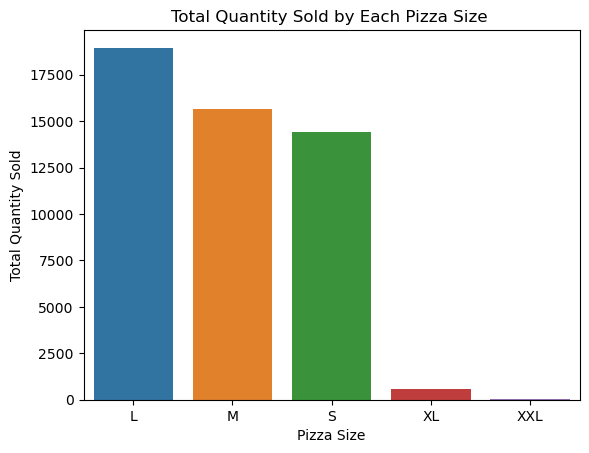

In [11]:
#Top selling pizza size
#pizza_count = pd.DataFrame(sales_df.groupby('pizza_name')['quantity'].sum())
pizza_count_size=sales_df.pivot_table(columns='pizza_size', values='quantity', aggfunc='sum')
sns.barplot(pizza_count_size)
plt.xlabel('Pizza Size')
plt.ylabel('Total Quantity Sold')
plt.title('Total Quantity Sold by Each Pizza Size ')
plt.show()


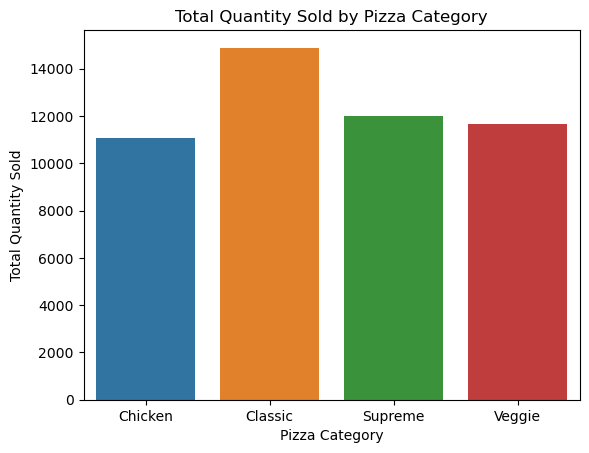

In [12]:
#Top selling pizza category
#pizza_count = pd.DataFrame(sales_df.groupby('pizza_name')['quantity'].sum())
pizza_count_cat=sales_df.pivot_table(columns='pizza_category', values='quantity', aggfunc='sum')
sns.barplot(pizza_count_cat)
plt.xlabel('Pizza Category')
plt.ylabel('Total Quantity Sold')
plt.title('Total Quantity Sold by Pizza Category')
plt.show()


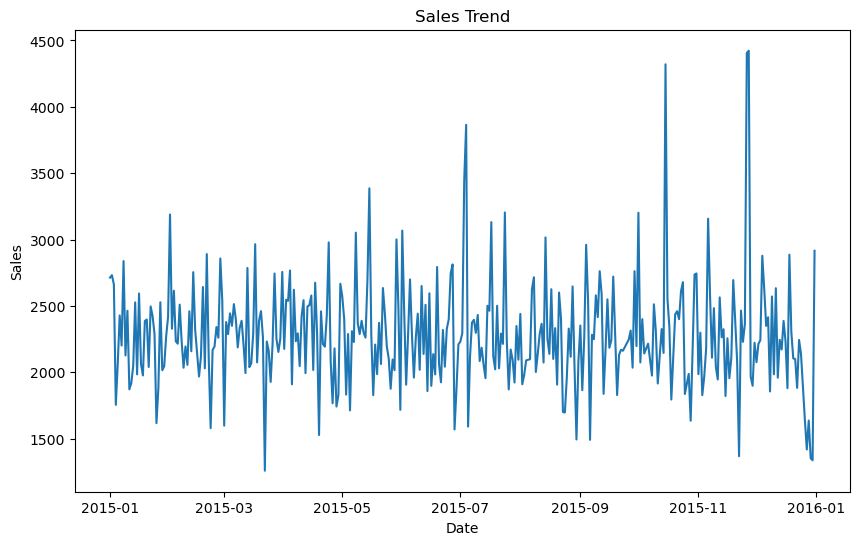

In [13]:
#Sales Trend
#pizza_sales_trend=sales_df.pivot_table(index='order_date',columns='total_price', aggfunc='sum')
sales_by_date = sales_df.groupby('order_date')['total_price'].sum().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_by_date, x='order_date', y='total_price')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend')
plt.show()

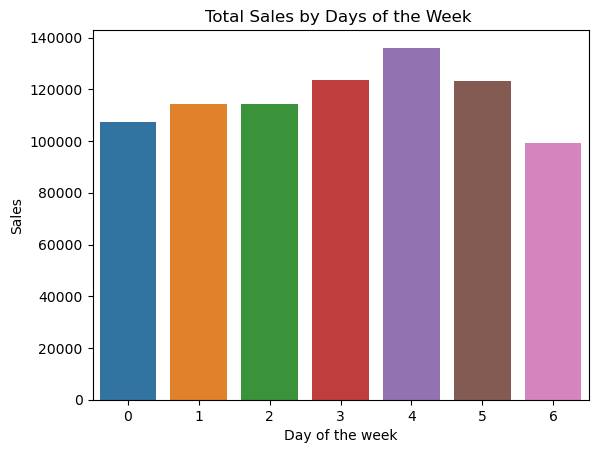

In [15]:
#Pizza sales by days
#pizza_count = pd.DataFrame(sales_df.groupby('pizza_name')['quantity'].sum())
pizza_sales_day=sales_df.pivot_table(columns='day_of_week', values='total_price', aggfunc='sum')
sns.barplot(pizza_sales_day)
plt.xlabel('Day of the week')
plt.ylabel('Sales')
plt.title('Total Sales by Days of the Week ')
plt.show()


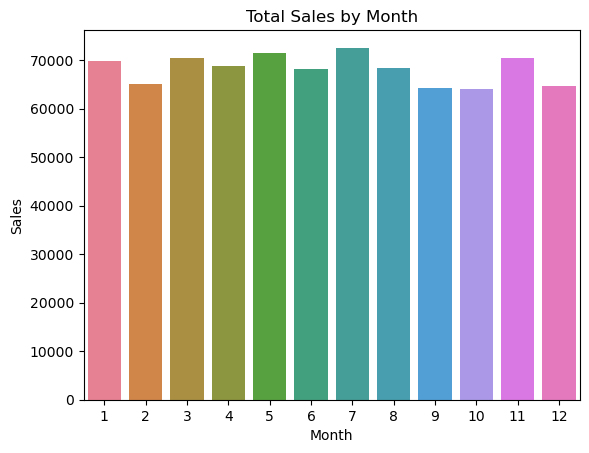

In [16]:
#Pizza sales by month
#pizza_count = pd.DataFrame(sales_df.groupby('pizza_name')['quantity'].sum())
pizza_sales_month=sales_df.pivot_table(columns='month', values='total_price', aggfunc='sum')
sns.barplot(pizza_sales_month)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Total Sales by Month')
plt.show()


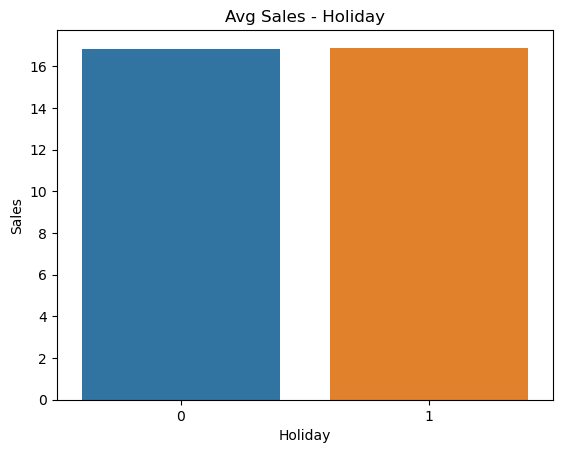

In [17]:
#Pizza sales on normal vs holidays
#pizza_count = pd.DataFrame(sales_df.groupby('pizza_name')['quantity'].sum())
pizza_sales_holiday=sales_df.pivot_table(columns='ind_holiday', values='total_price', aggfunc='mean')
sns.barplot(pizza_sales_holiday)
plt.xlabel('Holiday')
plt.ylabel('Sales')
plt.title('Avg Sales - Holiday')
plt.show()

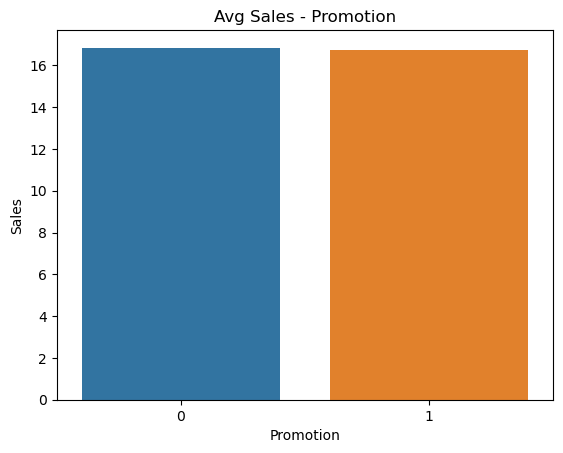

In [18]:
#Pizza sales on normal vs holidays
#pizza_count = pd.DataFrame(sales_df.groupby('pizza_name')['quantity'].sum())
pizza_sales_promotion=sales_df.pivot_table(columns='promotions', values='total_price', aggfunc='mean')
sns.barplot(pizza_sales_promotion)
plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.title('Avg Sales - Promotion')
plt.show()

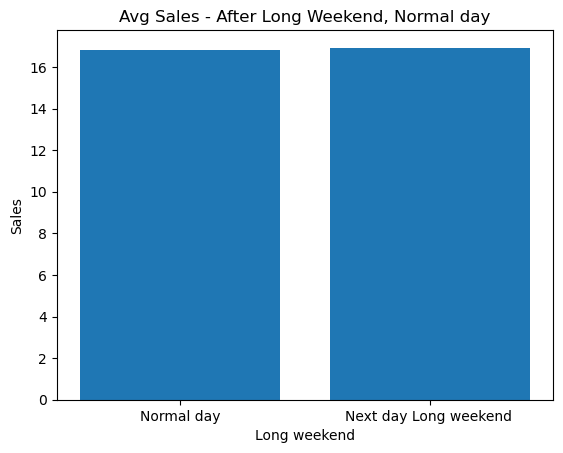

In [19]:
#Long weekend sales

#determine dates after long weekends, assuming 3 days as long weekend (F,S,S or S,S,M)
   
long_weekends=pd.DataFrame(ind_holidays.keys(),columns=['holiday_date'])
#day after long week ends
def next_work_day(holiday_date):
    if holiday_date.weekday() == 4 :  # Friday
        return holiday_date + pd.Timedelta(days=3)
    elif holiday_date.weekday() == 0:  # Monday
        return holiday_date + pd.Timedelta(days=1)
    else:
        return 0

long_weekends['next_work_day'] = long_weekends['holiday_date'].apply(next_work_day)

next_workday=[i for i in long_weekends['next_work_day'] if i!=0]

next_workday_df= sales_df[sales_df['order_date'].isin(next_workday)]
next_workday_avg=next_workday_df['total_price'].mean()
normal_day_df=sales_df[~sales_df['order_date'].isin(next_workday)]
normal_day_avg=normal_day_df['total_price'].mean()
avg_sales_longwe={'Normal day':normal_day_avg,'Next day Long weekend ':next_workday_avg}
plt.bar(avg_sales_longwe.keys(),avg_sales_longwe.values())
plt.xlabel('Long weekend')
plt.ylabel('Sales')
plt.title('Avg Sales - After Long Weekend, Normal day')
plt.show()


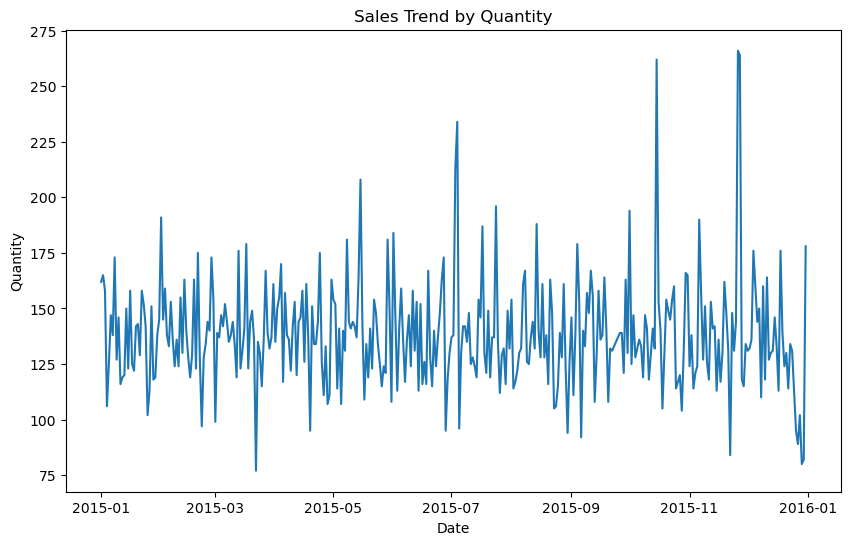

In [20]:
#Sales Trend by quantity
#pizza_sales_trend=sales_df.pivot_table(index='order_date',columns='total_price', aggfunc='sum')
quantity_sales_by_date = sales_df.groupby('order_date')['quantity'].sum().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=quantity_sales_by_date, x='order_date', y='quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Sales Trend by Quantity')
plt.show()

***Step2 b:Model Selection***

In [43]:
quantity_sales_by_date = sales_df.groupby('order_date')['quantity'].sum().reset_index()
all_dates = pd.date_range(start=quantity_sales_by_date['order_date'].min(),
                          end=quantity_sales_by_date['order_date'].max(),
                          freq='D')

quantity_sales_by_date = quantity_sales_by_date.set_index('order_date').reindex(all_dates)
quantity_sales_by_date = quantity_sales_by_date.reset_index().rename(columns={'index': 'order_date'})
quantity_sales_by_date['quantity'].interpolate(inplace=True)
quantity_sales_by_date = quantity_sales_by_date.set_index('order_date')
quantity_sales_by_date

,quantity
order_date,
2015-01-01,162.0
2015-01-02,165.0
2015-01-03,158.0
2015-01-04,106.0
2015-01-05,125.0
...,...
2015-12-27,89.0
2015-12-28,102.0
2015-12-29,80.0


In [22]:
#ARIMA
#Check for stationarity
result = adfuller(quantity_sales_by_date["quantity"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

ADF Statistic: -5.125813813549091
p-value: 1.2436751309107068e-05
Stationary


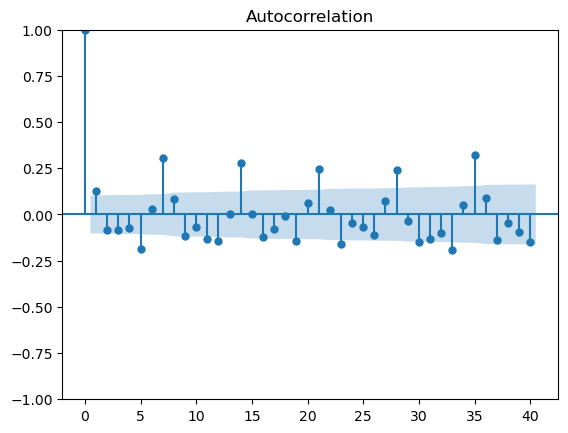

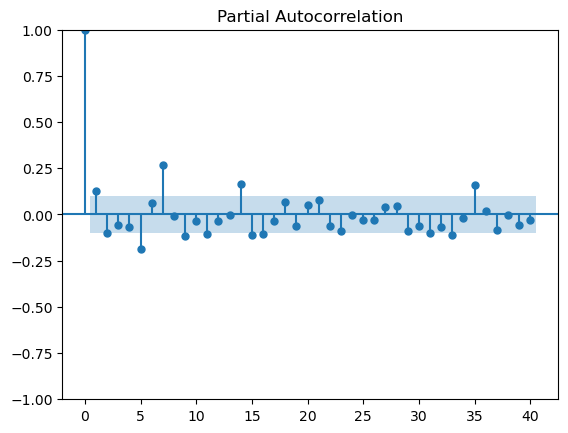

In [23]:
#ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)
plot_acf(quantity_sales_by_date["quantity"], lags=40) #q=3
plot_pacf(quantity_sales_by_date["quantity"], lags=40) #p=2 or 3
plt.show()

In [ ]:
!pip install pmdarima 

In [24]:
#Determine the hyperparameters
stepwise_fit=auto_arima(quantity_sales_by_date["quantity"],start_p=0, start_q=0, 
                        max_p=20,
                           max_q=20, 
                        m=1,scoring='mae',stationary=False,stepwise=False,trace=True)
stepwise_fit.summary

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=3366.879, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=3361.682, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=3362.129, Time=0.27 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=3359.585, Time=0.42 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=3361.530, Time=0.68 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=3352.942, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=3362.876, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=3363.518, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=3365.286, Time=0.32 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=3361.291, Time=0.73 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=3363.578, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=3361.030, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=3363.353, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=3348.164, Time=0.75 sec
 ARIMA(3,0,0)(0

<bound method ARIMA.summary of ARIMA(order=(2, 0, 3), scoring='mae', scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)>

In [44]:
#Train,test split
train_size=int(0.8*len(quantity_sales_by_date))
train=quantity_sales_by_date.iloc[:train_size]
test=quantity_sales_by_date.iloc[train_size:]

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  292
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1294.195
Date:                Thu, 05 Dec 2024   AIC                           2602.389
Time:                        13:08:19   BIC                           2628.127
Sample:                    01-01-2015   HQIC                          2612.699
                         - 10-19-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        138.5894      1.213    114.254      0.000     136.212     140.967
ar.L1          1.2471      0.007    171.517      0.000       1.233       1.261
ar.L2         -0.9997      0.002   -482.631      0.0

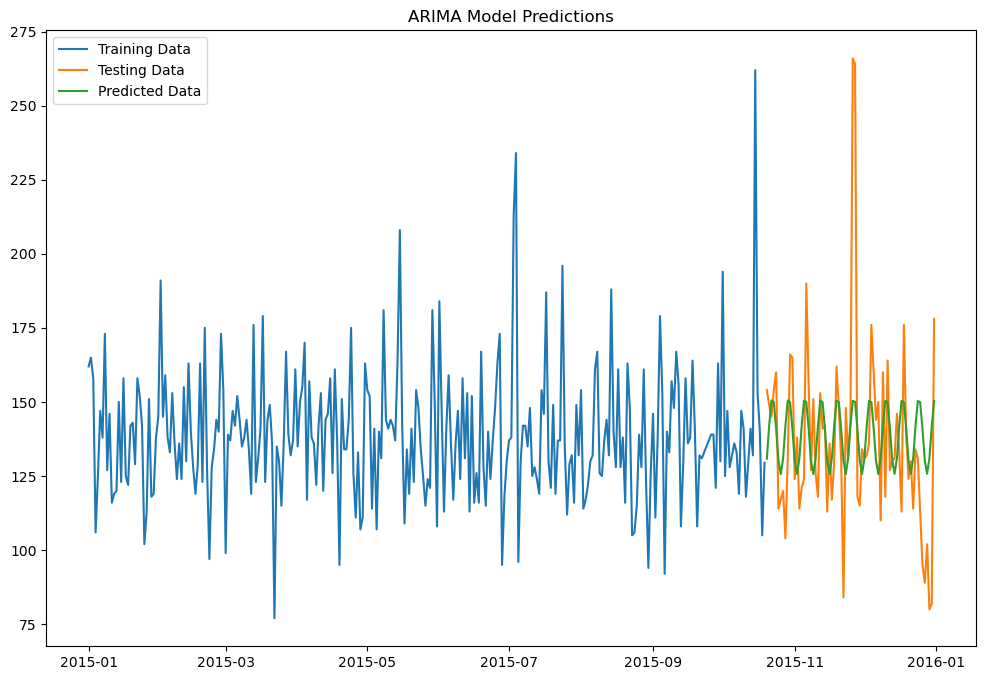

MAPE: 0.15300083801669698


{'ARIMA': 0.15300083801669698}

In [45]:

model=ARIMA(train['quantity'],order=(2,0,3))
arima_model = model.fit()
print(arima_model.summary())

arima_pred=arima_model.predict(start=train_size,end=len(quantity_sales_by_date)-1,typ='levels')
print(arima_pred)

plt.figure(figsize=(12,8))
plt.plot(train['quantity'], label='Training Data')
plt.plot(test['quantity'], label='Testing Data')
plt.plot(arima_pred, label='Predicted Data')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show()


#Metrics dictionary to compare all the model performance
metrics_dict=dict()
mape = mean_absolute_percentage_error(np.array(test['quantity']), np.array(arima_pred))
metrics_dict['ARIMA']=mape
print(f"MAPE: {mape}")
metrics_dict

#SARIMA model

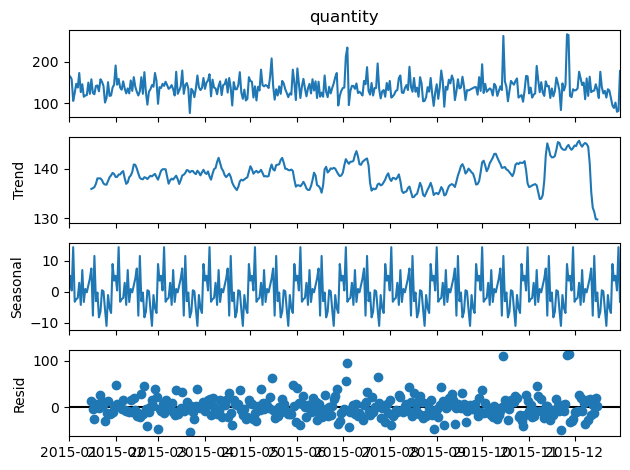

In [28]:
# Assuming `quantity_sales_by_date` is set with 'order_date' as index
result = seasonal_decompose(quantity_sales_by_date['quantity'], model='additive', period=30)

# Plot the decomposition
result.plot()
plt.show()

In [29]:
#Determine the hyperparameters
stepwise_fit=auto_arima(quantity_sales_by_date["quantity"], seasonal=True, m=30, stepwise=True, trace=True)
stepwise_fit.summary

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=3355.274, Time=6.67 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=3366.879, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=3358.134, Time=4.05 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=3355.756, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=4647.169, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[30] intercept   : AIC=3360.842, Time=3.30 sec
 ARIMA(2,0,2)(1,0,0)[30] intercept   : AIC=3365.633, Time=3.17 sec
 ARIMA(2,0,2)(2,0,1)[30] intercept   : AIC=3372.292, Time=17.63 sec
 ARIMA(2,0,2)(1,0,2)[30] intercept   : AIC=3365.888, Time=16.76 sec
 ARIMA(2,0,2)(0,0,0)[30] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,0,2)(0,0,2)[30] intercept   : AIC=inf, Time=11.55 sec
 ARIMA(2,0,2)(2,0,0)[30] intercept   : AIC=3360.992, Time=12.61 sec
 ARIMA(2,0,2)(2,0,2)[30] intercept   : AIC=inf, Time=14.68 sec
 ARIMA(1,0,2)(1,0,1)[30] intercept   : AIC=3361.146, Time=3.92 sec
 ARIMA(2,0,1)(1,0,1)[30] inte

<bound method ARIMA.summary of ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(1, 0, 1, 30),
      suppress_warnings=True)>

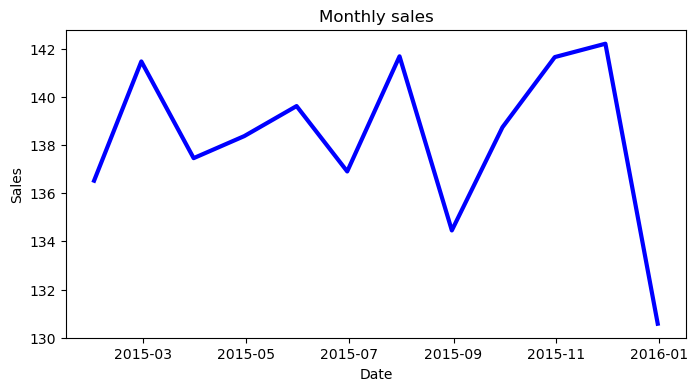

In [30]:
monthly_sales = quantity_sales_by_date.resample('M').mean()
plt.figure(figsize=(8, 4))
plt.plot(monthly_sales['quantity'], linewidth=3,c='blue')
plt.title("Monthly sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

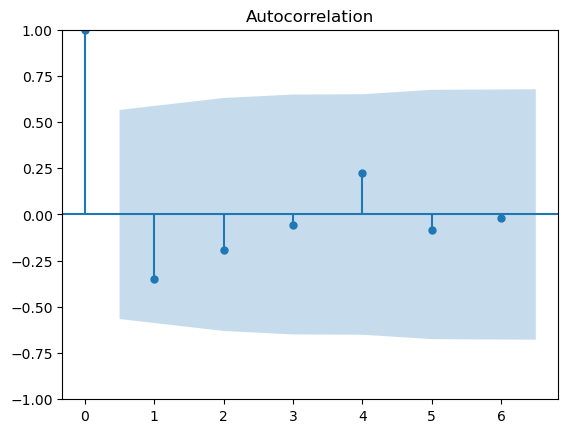

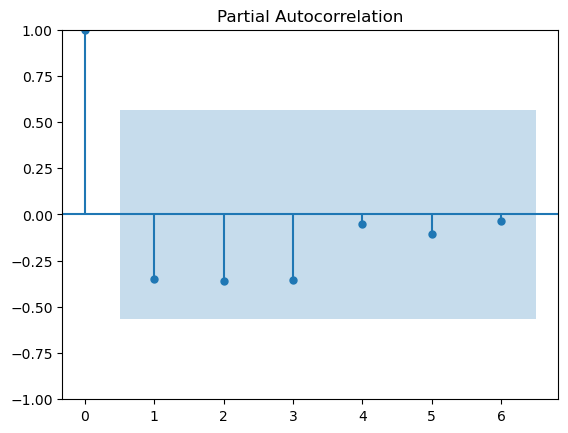

In [31]:
plot_acf(monthly_sales)
plot_pacf(monthly_sales)
plt.show()

                                      SARIMAX Results                                       
Dep. Variable:                             quantity   No. Observations:                  292
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 30)   Log Likelihood               -1327.668
Date:                              Thu, 05 Dec 2024   AIC                           2669.335
Time:                                      13:08:37   BIC                           2695.073
Sample:                                  01-01-2015   HQIC                          2679.645
                                       - 10-19-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0047      0.019      0.243      0.808      -0.033       0.042
ar.L2          0.99

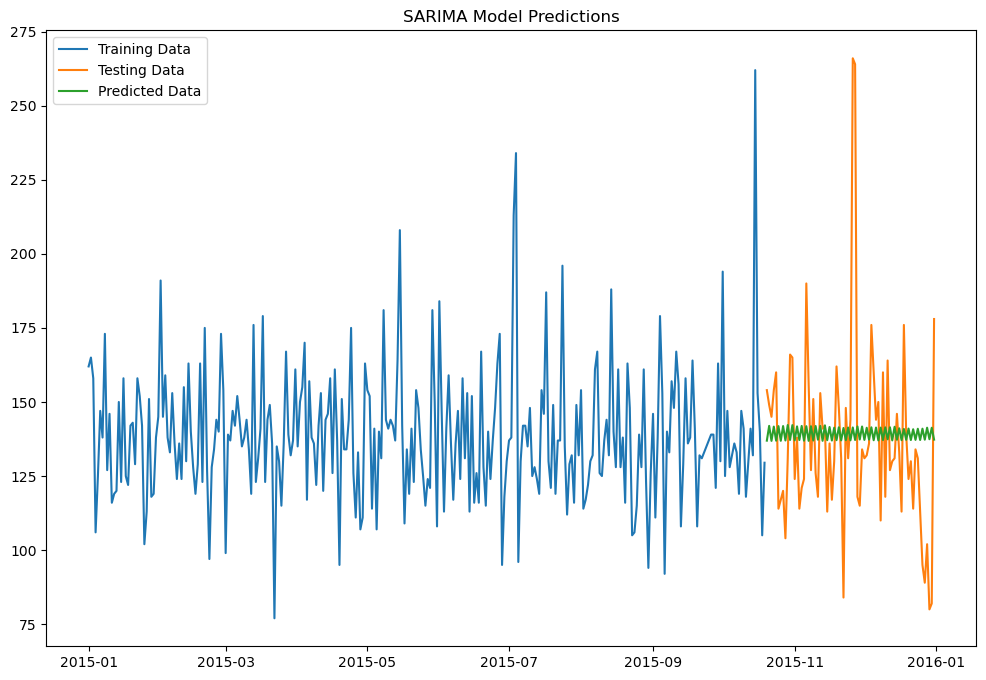

MAPE: 0.16930466021621593


{'ARIMA': 0.15300083801669698, 'SARIMA': 0.16930466021621593}

In [46]:
model = SARIMAX(train['quantity'], 
                       order=(2, 0, 2),  # AR, differencing, MA order (p, d, q)
                       seasonal_order=(1, 0, 1, 30))  # Seasonal AR, differencing, MA order (P, D, Q, m)
sarima_model = model.fit()
print(sarima_model.summary())

sarima_pred=sarima_model.predict(start=train_size,end=len(quantity_sales_by_date)-1,typ='levels')
print(sarima_pred)

plt.figure(figsize=(12,8))
plt.plot(train['quantity'], label='Training Data')
plt.plot(test['quantity'], label='Testing Data')
plt.plot(sarima_pred, label='Predicted Data')
plt.legend()
plt.title('SARIMA Model Predictions')
plt.show()


mape = mean_absolute_percentage_error(np.array(test['quantity']), np.array(sarima_pred))
metrics_dict['SARIMA']=mape
print(f"MAPE: {mape}")
metrics_dict

#Prophet Model

In [ ]:
!pip install prophet

In [33]:
quantity_sales_by_date_df = sales_df.groupby('order_date')['quantity'].sum().reset_index()
quantity_sales_by_date_df.columns=['ds','y']

<Axes: xlabel='ds'>

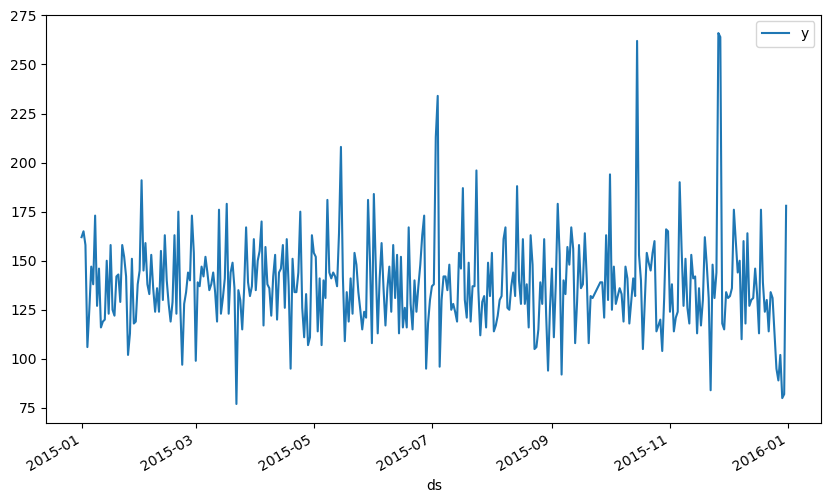

In [34]:
quantity_sales_by_date_df.plot(x='ds',y='y',figsize=(10,6))

13:08:49 - cmdstanpy - INFO - Chain [1] start processing
13:08:50 - cmdstanpy - INFO - Chain [1] done processing


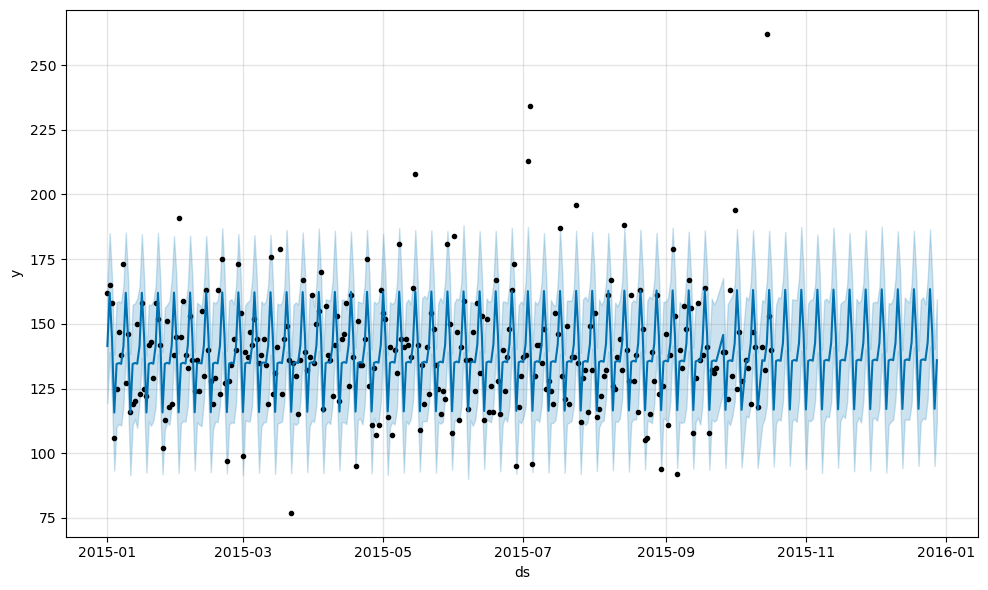

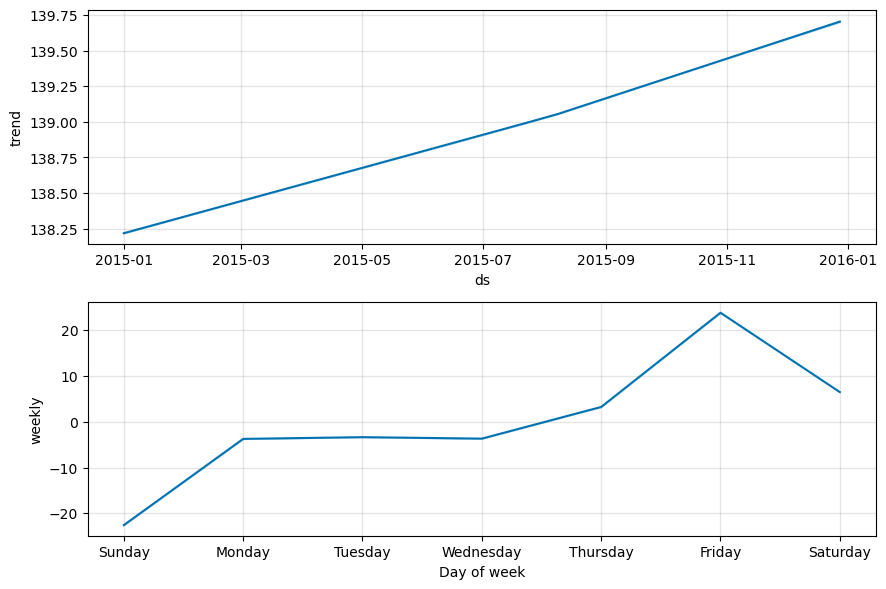

MAPE: 0.12116516094601659


{'ARIMA': 0.15300083801669698,
 'SARIMA': 0.16930466021621593,
 'Prophet': 0.12116516094601659}

In [47]:
train_size=int(0.8*len(quantity_sales_by_date_df))
train_p=quantity_sales_by_date_df.iloc[:train_size]
test_p=quantity_sales_by_date_df.iloc[train_size:]
prophet_model=Prophet()
prophet_model.fit(train_p)
future = prophet_model.make_future_dataframe(periods=len(test_p))
prophet_pred=prophet_model.predict(future)

#print(prophet_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
prophet_model.plot(prophet_pred)
prophet_model.plot_components(prophet_pred)

plt.show()


merged_data = pd.merge(test_p[['ds', 'y']], prophet_pred[['ds', 'yhat']], on='ds', how='inner')
merged_data = merged_data.dropna(subset=['y', 'yhat'])
mape=mean_absolute_percentage_error(np.array(merged_data['y'].values), np.array(merged_data['yhat'].values))
metrics_dict['Prophet']=mape
print(f"MAPE: {mape}")
metrics_dict


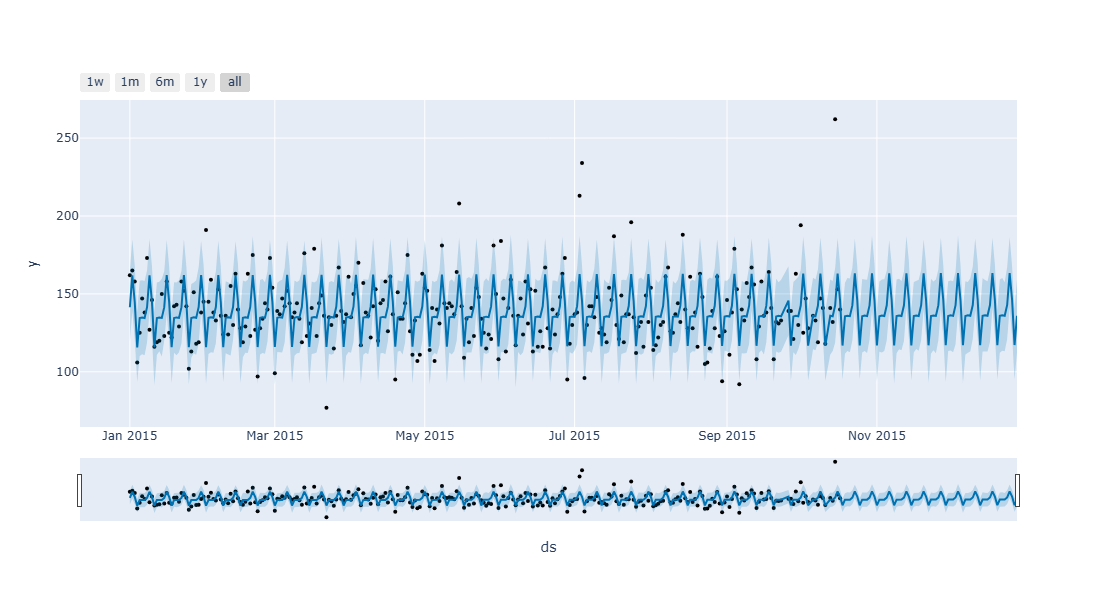

In [48]:
plot_plotly(prophet_model, prophet_pred)

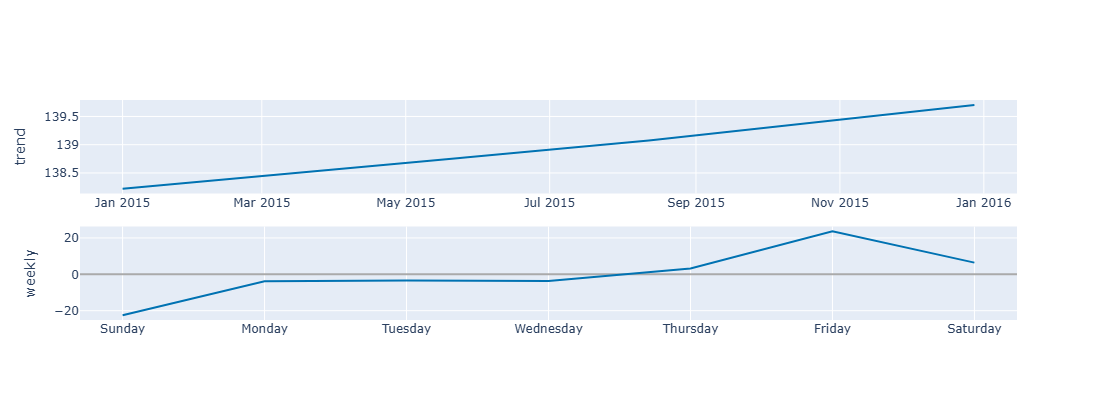

In [49]:
plot_components_plotly(prophet_model, prophet_pred)

***LSTM***

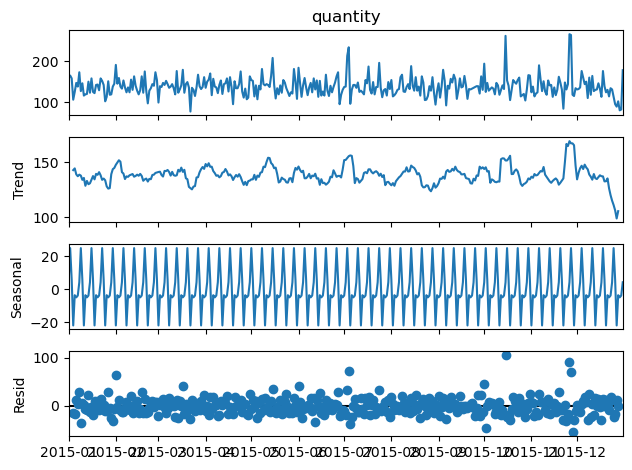

In [50]:
# Assuming `quantity_sales_by_date` is set with 'order_date' as index
result = seasonal_decompose(quantity_sales_by_date['quantity'])

# Plot the decomposition
result.plot()
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1333
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0853
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0797
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0961
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1000
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0918
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0790
Epoch 8/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0894
Epoch 9/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0941
Epoch 10/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0964
Epoch 11/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0818
Epoch 12/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0859
Epoch 13/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0846
Epoch 14/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0902
Epoch 15/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 

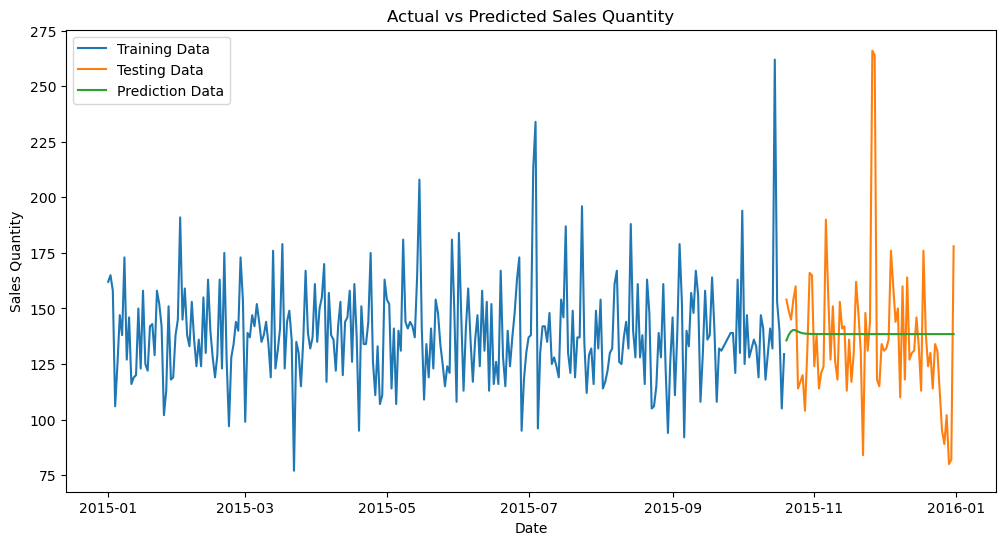

MAPE: 0.1645482064259204


{'ARIMA': 0.15300083801669698,
 'SARIMA': 0.16930466021621593,
 'Prophet': 0.12116516094601659,
 'LSTM': 0.1645482064259204}

In [51]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train=scaler.transform(train)
#scaled_test=scaler.transform(test)


n_input=30
n_features=1 #more than 1 for multiple timeseries
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)


#Building model
lstm_model= Sequential()
lstm_model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
lstm_model.add(Dense(1)) #uptput layer
lstm_model.compile(optimizer='adam',loss='mae')

print(lstm_model.summary())
#fit model
lstm_model.fit(generator,epochs=50)


test_prediction=[]
first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
    current_pred=lstm_model.predict(current_batch)[0]

    test_prediction.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    #current_batch = np.append(current_batch[:, 1:, :], np.reshape(current_pred, (1, 1, n_features)), axis=1)

test_prediction=scaler.inverse_transform(test_prediction)
lstm_test_df=test.copy()
lstm_test_df['Prediction']=test_prediction
lstm_test_df

plt.figure(figsize=(12, 6))
plt.plot(train['quantity'], label='Training Data')
plt.plot(lstm_test_df['quantity'], label='Testing Data')
plt.plot(lstm_test_df['Prediction'], label='Prediction Data')
plt.title('Actual vs Predicted Sales Quantity')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()

mape = mean_absolute_percentage_error(np.array(lstm_test_df['quantity']), np.array(lstm_test_df['Prediction']))

metrics_dict['LSTM']=mape
print(f"MAPE: {mape}")
metrics_dict


In [ ]:
!pip install tensorflow

In [ ]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

***XGBoost***

MAPE: 0.1735


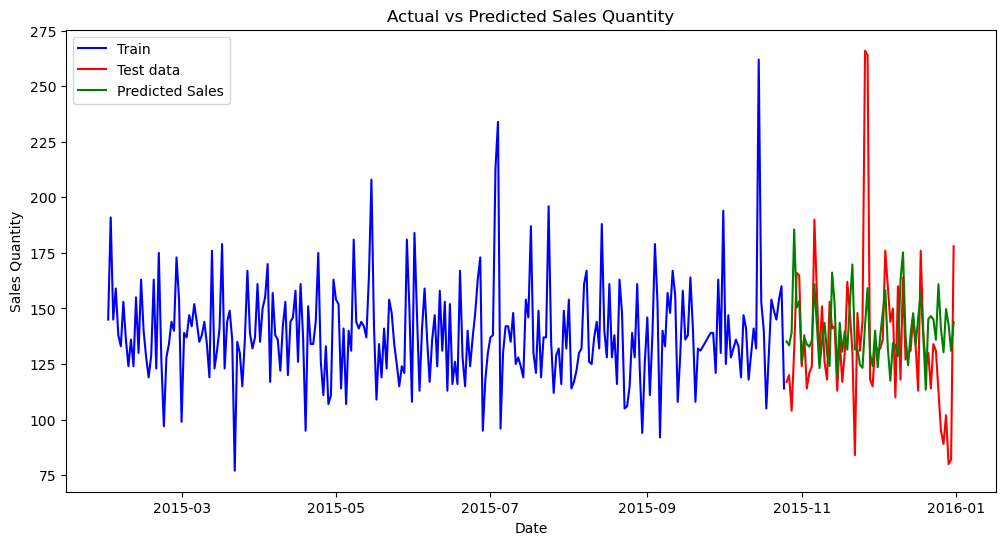

In [52]:
# Create lagged features
def create_lagged_features(data, lag=1):
    df = data.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['quantity'].shift(i)
    df.dropna(inplace=True)
    return df

# Create lagged features with a lag of 30 (e.g., previous 30 days)
lag = 30
lagged_data = create_lagged_features(quantity_sales_by_date, lag)

# Split into features (X) and target (y)
X = lagged_data.drop('quantity', axis=1)  # Features (lags)
y = lagged_data['quantity']  # Target (sales quantity)

# Split data into training and testing sets
train_size = int(0.8 * len(lagged_data))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Initialize and train XGBoost Regressor
xg_reg_model = xgb.XGBRegressor( learning_rate=0.1,max_depth=5, alpha=10, n_estimators=100)

# Train the model
xg_reg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg_model.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
metrics_dict['XGBoost']=mape
print(f'MAPE: {mape:.4f}')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train', color='blue')
plt.plot(y_test.index, y_test, label='Test data', color='red')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='green')
plt.title('Actual vs Predicted Sales Quantity')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()


In [53]:
Eval_df=pd.DataFrame(list(metrics_dict.items()), columns=['Model', 'MAPE'])
Eval_df

,Model,MAPE
0,ARIMA,0.153001
1,SARIMA,0.169305
2,Prophet,0.121165
3,LSTM,0.164548
4,XGBoost,0.173488


In [54]:
#Predicing sales for the next week for each pizza type
forecasted_sales={}
start_date=sales_df['order_date'].max() + timedelta(days=1)

for pizza_type in sales_df['pizza_name_id'].unique():
    input_df=sales_df[sales_df['pizza_name_id']==pizza_type].groupby(['order_date'])['quantity'].sum().reset_index()
    input_df.columns=['ds','y']
    prophet_model=Prophet()
    prophet_model.fit(input_df)
    
    #future = prophet_model.make_future_dataframe(periods=len(7))
    future_dates = pd.date_range(start= start_date, periods=7, freq='D')
    future_manual = pd.DataFrame({'ds': future_dates})
    prophet_pred=prophet_model.predict(future_manual)

    #print(prophet_pred[['ds','yhat']])
    forecasted_sales[pizza_type]=prophet_pred['yhat'].values

forecasted_sales

13:11:48 - cmdstanpy - INFO - Chain [1] start processing
13:11:48 - cmdstanpy - INFO - Chain [1] done processing
13:11:49 - cmdstanpy - INFO - Chain [1] start processing
13:11:49 - cmdstanpy - INFO - Chain [1] done processing
13:11:49 - cmdstanpy - INFO - Chain [1] start processing
13:11:49 - cmdstanpy - INFO - Chain [1] done processing
13:11:49 - cmdstanpy - INFO - Chain [1] start processing
13:11:49 - cmdstanpy - INFO - Chain [1] done processing
13:11:49 - cmdstanpy - INFO - Chain [1] start processing
13:11:49 - cmdstanpy - INFO - Chain [1] done processing
13:11:50 - cmdstanpy - INFO - Chain [1] start processing
13:11:50 - cmdstanpy - INFO - Chain [1] done processing
13:11:50 - cmdstanpy - INFO - Chain [1] start processing
13:11:50 - cmdstanpy - INFO - Chain [1] done processing
13:11:50 - cmdstanpy - INFO - Chain [1] start processing
13:11:50 - cmdstanpy - INFO - Chain [1] done processing
13:11:51 - cmdstanpy - INFO - Chain [1] start processing
13:11:51 - cmdstanpy - INFO - Chain [1]

{'hawaiian_m': array([1.70126664, 1.78177377, 1.66318648, 1.91804165, 2.00329058,
        1.59221708, 1.72635411]),
 'classic_dlx_m': array([4.50859428, 3.66554543, 3.03385738, 3.83388639, 3.53500226,
        3.35917737, 3.80867346]),
 'five_cheese_l': array([4.97794399, 3.95060574, 3.14847463, 3.41571665, 3.76451126,
        3.37044004, 3.60177673]),
 'ital_supr_l': array([2.75701404, 2.28865974, 2.51193429, 2.63319377, 2.43430408,
        2.30611153, 2.79026204]),
 'mexicana_m': array([2.2194175 , 1.90122771, 1.52469096, 1.79466509, 1.47734556,
        1.89182975, 1.88778838]),
 'thai_ckn_l': array([5.17424756, 4.47114436, 3.70242143, 3.94557538, 4.03622866,
        4.36389725, 4.46858483]),
 'ital_supr_m': array([2.66005568, 2.42097202, 2.12701489, 2.66776288, 2.53094675,
        2.81490141, 2.8252325 ]),
 'prsc_argla_l': array([2.04363662, 1.76047058, 1.39336564, 1.69923515, 1.7905965 ,
        1.67517435, 1.48746065]),
 'bbq_ckn_s': array([2.06593644, 1.77097011, 1.62194785, 1.970

In [55]:
#Predicted sales df for each pizza type
forecasted_sales_df=pd.DataFrame(forecasted_sales)
forecasted_sales_df.index= pd.date_range(start= start_date, periods=7, freq='D')
forecasted_sales_df

,hawaiian_m,classic_dlx_m,five_cheese_l,ital_supr_l,mexicana_m,thai_ckn_l,ital_supr_m,prsc_argla_l,bbq_ckn_s,the_greek_s,...,napolitana_m,spin_pesto_m,brie_carre_s,ckn_alfredo_l,calabrese_s,the_greek_l,soppressata_m,soppressata_s,calabrese_l,the_greek_xxl
2016-01-01,1.701267,4.508594,4.977944,2.757014,2.219418,5.174248,2.660056,2.043637,2.065936,1.670289,...,1.676512,1.666039,2.083581,1.186865,1.411162,1.849198,1.486335,1.417015,1.465299,1.0
2016-01-02,1.781774,3.665545,3.950606,2.288660,1.901228,4.471144,2.420972,1.760471,1.770970,1.337349,...,1.368759,1.915576,1.571460,1.262810,1.117270,1.446616,1.386225,1.554007,1.410329,1.0
2016-01-03,1.663186,3.033857,3.148475,2.511934,1.524691,3.702421,2.127015,1.393366,1.621948,1.190348,...,1.449143,1.566835,2.166884,1.292153,0.966342,1.272265,1.224836,1.659805,1.401800,1.0
2016-01-04,1.918042,3.833886,3.415717,2.633194,1.794665,3.945575,2.667763,1.699235,1.970488,1.201582,...,1.448114,1.320399,1.869010,1.285588,1.225979,1.537236,1.190274,1.249124,1.402302,1.0
2016-01-05,2.003291,3.535002,3.764511,2.434304,1.477346,4.036229,2.530947,1.790597,1.828900,1.263580,...,1.583872,1.516987,1.947940,1.156592,1.115178,1.406542,1.454031,1.331049,1.624564,1.0
2016-01-06,1.592217,3.359177,3.370440,2.306112,1.891830,4.363897,2.814901,1.675174,1.685942,1.315759,...,1.449501,1.430351,1.798546,1.219057,1.054065,1.261354,1.571198,1.459744,1.504860,1.0
2016-01-07,1.726354,3.808673,3.601777,2.790262,1.887788,4.468585,2.825232,1.487461,1.655677,1.498275,...,1.372748,1.269623,2.117075,1.008122,1.170353,1.298485,1.482857,1.329989,1.392049,1.0


In [56]:
total_forecasted_sales_df=pd.DataFrame(forecasted_sales_df.sum(axis=0))
total_forecasted_sales_df

,0
hawaiian_m,12.386130
classic_dlx_m,25.744737
five_cheese_l,26.229469
ital_supr_l,17.721479
mexicana_m,12.696965
...,...
the_greek_l,10.071694
soppressata_m,9.795756
soppressata_s,10.000732
calabrese_l,10.201203


In [57]:
total_ingredient_df=pd.merge(ingredient_df,total_forecasted_sales_df,left_on='pizza_name_id',right_index=True)
total_ingredient_df=total_ingredient_df.rename(columns={0:'Total_quantity_forecasted'})
total_ingredient_df['Total_Items_Qty_In_Grams']=total_ingredient_df['Items_Qty_In_Grams']*total_ingredient_df['Total_quantity_forecasted']
total_ingredient_df

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,Total_quantity_forecasted,Total_Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,20.268875,810.755003
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,20.268875,304.033126
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,20.268875,405.377501
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,20.268875,608.066252
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,20.268875,1216.132504
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,14.177392,283.547843
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,14.177392,283.547843
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,14.177392,141.773921
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,14.177392,212.660882


In [58]:
purchase_order=pd.DataFrame(total_ingredient_df.groupby('pizza_ingredients')['Total_Items_Qty_In_Grams'].agg(sum))
purchase_order=purchase_order.rename(columns={'Total_Items_Qty_In_Grams':'Total Quantity (gms)'})
purchase_order=purchase_order.rename_axis('Pizza Ingredients')

purchase_order.to_csv('Purchase_Order.csv')

In [59]:
purchase_order

,Total Quantity (gms)
Pizza Ingredients,
?duja Salami,1352.225669
Alfredo Sauce,502.202921
Anchovies,1031.060560
Artichokes,3471.059903
Arugula,396.197034
...,...
Sun-dried Tomatoes,639.293906
Thai Sweet Chilli Sauce,1276.318557
Thyme,67.772480
